# MSNP

In this notebook I demonstrate how you can use MSNP network for human pose estimation.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.transforms as transforms

from network import MSPN
from config import get_config
from test import get_image_from_url

### Loading

First we load the model from the GDrive link given in the repo README and place it on this same level as this notebook.

In [2]:
cfg = get_config("coco")

In [3]:
model = MSPN(cfg)

In [4]:
state_dict = torch.load("drive-download-20210107T043037Z-001/mspn_2xstg_coco.pth", map_location="cpu")
state_dict = state_dict['model']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [194]:
two_cricket_players = get_image_from_url("https://miro.medium.com/max/1200/1*56MtNM2fh_mdG3iGnD7_ZQ.jpeg")

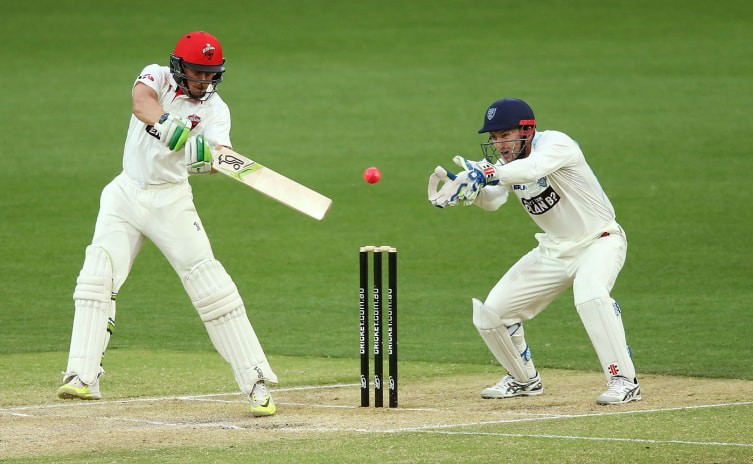

In [195]:
two_cricket_players

In [204]:
# define the image transformations to apply to each image
image_transformations = transforms.Compose([
    transforms.Resize((256, 192)),                               # resize to a (256,256) image
    transforms.ToTensor(),                                # convert to tensor
    transforms.Normalize(cfg.INPUT.MEANS, cfg.INPUT.STDS),    # normalise image according to imagenet valuess
])

In [197]:
out = image_transformations(two_cricket_players)
out.size()

torch.Size([3, 256, 192])

In [205]:
input_ = out.view(1, *out.size())
outputs = model(input_)
outputs = outputs.detach().numpy()
outputs.shape

(1, 17, 64, 48)

In [199]:
kernel=11
shifts=[0.25]

nr_img = outputs.shape[0]
preds = np.zeros((nr_img, cfg.DATASET.KEYPOINT.NUM, 2))
maxvals = np.zeros((nr_img, cfg.DATASET.KEYPOINT.NUM, 1))
for i in range(nr_img):
    score_map = outputs[i].copy()
    score_map = score_map / 255 + 0.5
    kps = np.zeros((cfg.DATASET.KEYPOINT.NUM, 2))
    scores = np.zeros((cfg.DATASET.KEYPOINT.NUM, 1))
    border = 10
    dr = np.zeros((cfg.DATASET.KEYPOINT.NUM,
        cfg.OUTPUT_SHAPE[0] + 2 * border, cfg.OUTPUT_SHAPE[1] + 2 * border))
    dr[:, border: -border, border: -border] = outputs[i].copy()
    for w in range(cfg.DATASET.KEYPOINT.NUM):
        dr[w] = cv2.GaussianBlur(dr[w], (kernel, kernel), 0)
    for w in range(cfg.DATASET.KEYPOINT.NUM):
        for j in range(len(shifts)):
            if j == 0:
                lb = dr[w].argmax()
                y, x = np.unravel_index(lb, dr[w].shape)
                dr[w, y, x] = 0
                x -= border
                y -= border
            lb = dr[w].argmax()
            py, px = np.unravel_index(lb, dr[w].shape)
            dr[w, py, px] = 0
            px -= border + x
            py -= border + y
            ln = (px ** 2 + py ** 2) ** 0.5
            if ln > 1e-3:
                x += shifts[j] * px / ln
                y += shifts[j] * py / ln
        x = max(0, min(x, cfg.OUTPUT_SHAPE[1] - 1))
        y = max(0, min(y, cfg.OUTPUT_SHAPE[0] - 1))
        kps[w] = np.array([x * 4 + 2, y * 4 + 2])
        scores[w, 0] = score_map[w, int(round(y) + 1e-9), int(round(x) + 1e-9)]
        
        preds[i] = kps
        maxvals[i] = scores

In [200]:
preds

array([[[126.,  71.],
        [127.,  70.],
        [125.,  70.],
        [133.,  70.],
        [125.,  74.],
        [138.,  77.],
        [123.,  90.],
        [141.,  90.],
        [131., 106.],
        [122.,  95.],
        [129., 106.],
        [154., 133.],
        [142., 137.],
        [153., 166.],
        [125., 174.],
        [159., 206.],
        [134., 209.]]])

In [201]:
def visualize(img, joints):
    pairs = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
            [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
            [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]
    color = np.random.randint(0, 256, (len(pairs), 3)).tolist()

    for i in range(2):
        if joints[i, 0] > 0 and joints[i, 1] > 0:
            cv2.circle(img, tuple(joints[i, :2]), 2, tuple(color[i]), 2)

    def draw_line(img, p1, p2, c):
        if p1[0] > 0 and p1[1] > 0 and p2[0] > 0 and p2[1] > 0:
            cv2.line(img, tuple(p1), tuple(p2), c, 2)

    for i, pair in enumerate(pairs):
        draw_line(img, joints[pair[0] - 1], joints[pair[1] - 1], color[i])

    return img

In [202]:
resize = two_cricket_players.resize((192, 256))
cv2img = cv2.cvtColor(np.array(resize), cv2.COLOR_RGB2BGR)
cv2img = cv2.cvtColor(cv2img, cv2.COLOR_RGB2BGR)
out_img = visualize(cv2img, preds[0].astype(int))
out_img = cv2.resize(out_img, (256, 192))

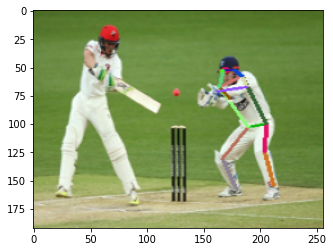

In [203]:
plt.imshow(out_img)

## Pass to ONNX

In [207]:
torch.onnx.export(
    model = model,
    args = input_,
    f = 'drive-download-20210107T043037Z-001/mspn_2xstg_coco.onnx',
    export_params=True,
    verbose=True,
    training=False
)

/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py:299: UserWarning: It is recommended that constant folding be turned off ('do_constant_folding=False') when exporting the model in training-amenable mode, i.e. with 'training=TrainingMode.TRAIN' or 'training=TrainingMode.PRESERVE' (when model is in training mode). Otherwise, some learnable model parameters may not translate correctly in the exported ONNX model because constant folding mutates model parameters. Please consider turning off constant folding or setting the training=TrainingMode.EVAL.
  warnings.warn("It is recommended that constant folding be turned off ('do_constant_folding=False') "
/usr/local/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:266: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attr

graph(%input.1 : Float(1:147456, 3:49152, 256:192, 192:1, requires_grad=0, device=cpu),
      %top.conv.conv.weight : Float(64:147, 3:49, 7:7, 7:1, requires_grad=1, device=cpu),
      %top.conv.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %top.conv.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.conv.weight : Float(64:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv

RuntimeError: ONNX export failed: Couldn't export operator aten::upsample_bilinear2d

Defined at:
/usr/local/lib/python3.9/site-packages/torch/nn/functional.py(3151): interpolate
/Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py(202): forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(709): _slow_forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(725): _call_impl
/Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py(257): forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(709): _slow_forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(725): _call_impl
/Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py(288): forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(709): _slow_forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(725): _call_impl
/Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py(362): forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(709): _slow_forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(725): _call_impl
/usr/local/lib/python3.9/site-packages/torch/jit/_trace.py(116): wrapper
/usr/local/lib/python3.9/site-packages/torch/jit/_trace.py(125): forward
/usr/local/lib/python3.9/site-packages/torch/nn/modules/module.py(727): _call_impl
/usr/local/lib/python3.9/site-packages/torch/jit/_trace.py(1148): _get_trace_graph
/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py(342): _trace_and_get_graph_from_model
/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py(379): _create_jit_graph
/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py(409): _model_to_graph
/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py(632): _export
/usr/local/lib/python3.9/site-packages/torch/onnx/utils.py(85): export
/usr/local/lib/python3.9/site-packages/torch/onnx/__init__.py(225): export
<ipython-input-207-4ea3b5b00544>(1): <module>
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3418): run_code
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3338): run_ast_nodes
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3146): run_cell_async
/usr/local/lib/python3.9/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2923): _run_cell
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2877): run_cell
/usr/local/lib/python3.9/site-packages/ipykernel/zmqshell.py(539): run_cell
/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py(302): do_execute
/usr/local/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py(540): execute_request
/usr/local/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py(265): dispatch_shell
/usr/local/lib/python3.9/site-packages/tornado/gen.py(234): wrapper
/usr/local/lib/python3.9/site-packages/ipykernel/kernelbase.py(362): process_one
/usr/local/lib/python3.9/site-packages/tornado/gen.py(775): run
/usr/local/lib/python3.9/site-packages/tornado/gen.py(814): inner
/usr/local/lib/python3.9/site-packages/tornado/ioloop.py(741): _run_callback
/usr/local/lib/python3.9/site-packages/tornado/ioloop.py(688): <lambda>
/usr/local/Cellar/python@3.9/3.9.1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py(80): _run
/usr/local/Cellar/python@3.9/3.9.1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py(1890): _run_once
/usr/local/Cellar/python@3.9/3.9.1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py(596): run_forever
/usr/local/lib/python3.9/site-packages/tornado/platform/asyncio.py(199): start
/usr/local/lib/python3.9/site-packages/ipykernel/kernelapp.py(612): start
/usr/local/lib/python3.9/site-packages/traitlets/config/application.py(845): launch_instance
/usr/local/lib/python3.9/site-packages/ipykernel_launcher.py(16): <module>
/usr/local/Cellar/python@3.9/3.9.1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py(87): _run_code
/usr/local/Cellar/python@3.9/3.9.1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py(197): _run_module_as_main


Graph we tried to export:
graph(%input.1 : Float(1:147456, 3:49152, 256:192, 192:1, requires_grad=0, device=cpu),
      %top.conv.conv.weight : Float(64:147, 3:49, 7:7, 7:1, requires_grad=1, device=cpu),
      %top.conv.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %top.conv.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %top.conv.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.conv.weight : Float(64:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.downsample.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.downsample.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.downsample.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.downsample.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.0.downsample.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.0.downsample.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.conv.weight : Float(64:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.1.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.conv.weight : Float(64:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer1.2.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.conv.weight : Float(128:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.downsample.conv.weight : Float(512:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.downsample.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.downsample.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.downsample.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.0.downsample.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.0.downsample.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.1.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.2.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer2.3.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.conv.weight : Float(256:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.downsample.conv.weight : Float(1024:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.downsample.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.downsample.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.downsample.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.0.downsample.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.0.downsample.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.1.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.2.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.3.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.4.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer3.5.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.conv.weight : Float(512:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.downsample.conv.weight : Float(2048:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.downsample.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.downsample.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.downsample.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.0.downsample.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.0.downsample.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.conv.weight : Float(512:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.1.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.conv.weight : Float(512:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.downsample.layer4.2.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.u_skip.conv.weight : Float(256:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.skip1.conv.weight : Float(2048:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip1.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip1.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip1.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip1.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.skip1.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.skip2.conv.weight : Float(2048:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip2.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip2.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip2.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage0.upsample.up1.skip2.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.upsample.up1.skip2.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.u_skip.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.skip1.conv.weight : Float(1024:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip1.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip1.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip1.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip1.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.skip1.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.skip2.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip2.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip2.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip2.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage0.upsample.up2.skip2.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.upsample.up2.skip2.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.u_skip.conv.weight : Float(256:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.skip1.conv.weight : Float(512:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.skip1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.skip2.conv.weight : Float(512:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage0.upsample.up3.skip2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage0.upsample.up3.skip2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.u_skip.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.skip1.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.skip1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.skip2.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.skip2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.skip2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.cross_conv.conv.weight : Float(64:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.cross_conv.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.cross_conv.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.cross_conv.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage0.upsample.up4.cross_conv.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage0.upsample.up4.cross_conv.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.conv.weight : Float(64:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.downsample.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.downsample.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.downsample.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.downsample.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.0.downsample.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.0.downsample.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.conv.weight : Float(64:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.1.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.conv.weight : Float(64:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu1.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.conv.weight : Float(64:576, 64:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.conv.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.bn.weight : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.bn.bias : Float(64:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.bn.running_mean : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu2.bn.running_var : Float(64:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.conv.weight : Float(256:64, 64:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer1.2.conv_bn_relu3.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.conv.weight : Float(128:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.downsample.conv.weight : Float(512:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.downsample.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.downsample.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.downsample.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.0.downsample.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.0.downsample.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.1.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.2.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.conv.weight : Float(128:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu1.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.conv.weight : Float(128:1152, 128:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.conv.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.bn.weight : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.bn.bias : Float(128:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.bn.running_mean : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu2.bn.running_var : Float(128:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.conv.weight : Float(512:128, 128:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer2.3.conv_bn_relu3.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.conv.weight : Float(256:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.downsample.conv.weight : Float(1024:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.downsample.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.downsample.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.downsample.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.0.downsample.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.0.downsample.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.1.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.2.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.3.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.4.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.conv.weight : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu2.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.conv.weight : Float(1024:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.conv.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.bn.weight : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.bn.bias : Float(1024:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.bn.running_mean : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer3.5.conv_bn_relu3.bn.running_var : Float(1024:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.conv.weight : Float(512:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.downsample.conv.weight : Float(2048:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.downsample.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.downsample.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.downsample.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.0.downsample.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.0.downsample.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.conv.weight : Float(512:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.1.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.conv.weight : Float(512:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu1.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.conv.weight : Float(512:4608, 512:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.conv.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.bn.weight : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.bn.bias : Float(512:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.bn.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu2.bn.running_var : Float(512:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.conv.weight : Float(2048:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.conv.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.bn.weight : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.bn.bias : Float(2048:1, requires_grad=1, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.bn.running_mean : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.downsample.layer4.2.conv_bn_relu3.bn.running_var : Float(2048:1, requires_grad=0, device=cpu),
      %stage1.upsample.up1.u_skip.conv.weight : Float(256:2048, 2048:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up1.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up1.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up1.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up1.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up1.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up2.u_skip.conv.weight : Float(256:1024, 1024:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up2.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up2.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up2.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up2.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up3.u_skip.conv.weight : Float(256:512, 512:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up3.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up3.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up3.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up3.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.u_skip.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.u_skip.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.u_skip.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.u_skip.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.u_skip.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.u_skip.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.up_conv.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.up_conv.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.up_conv.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.up_conv.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.up_conv.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.up_conv.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.res_conv1.conv.weight : Float(256:256, 256:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv1.conv.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv1.bn.weight : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv1.bn.bias : Float(256:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv1.bn.running_mean : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.res_conv1.bn.running_var : Float(256:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.res_conv2.conv.weight : Float(17:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv2.conv.bias : Float(17:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv2.bn.weight : Float(17:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv2.bn.bias : Float(17:1, requires_grad=1, device=cpu),
      %stage1.upsample.up4.res_conv2.bn.running_mean : Float(17:1, requires_grad=0, device=cpu),
      %stage1.upsample.up4.res_conv2.bn.running_var : Float(17:1, requires_grad=0, device=cpu)):
  %1009 : Float(1:786432, 64:12288, 128:96, 96:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2]](%input.1, %top.conv.conv.weight, %top.conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1010 : Float(1:786432, 64:12288, 128:96, 96:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1009, %top.conv.bn.weight, %top.conv.bn.bias, %top.conv.bn.running_mean, %top.conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1011 : Float(1:786432, 64:12288, 128:96, 96:1, requires_grad=1, device=cpu) = onnx::Relu(%1010) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1012 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::MaxPool[kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1011) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:585:0
  %1013 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1012, %stage0.downsample.layer1.0.conv_bn_relu1.conv.weight, %stage0.downsample.layer1.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1014 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1013, %stage0.downsample.layer1.0.conv_bn_relu1.bn.weight, %stage0.downsample.layer1.0.conv_bn_relu1.bn.bias, %stage0.downsample.layer1.0.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer1.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1015 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1014) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1016 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1015, %stage0.downsample.layer1.0.conv_bn_relu2.conv.weight, %stage0.downsample.layer1.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1017 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1016, %stage0.downsample.layer1.0.conv_bn_relu2.bn.weight, %stage0.downsample.layer1.0.conv_bn_relu2.bn.bias, %stage0.downsample.layer1.0.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer1.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1018 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1017) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1019 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1018, %stage0.downsample.layer1.0.conv_bn_relu3.conv.weight, %stage0.downsample.layer1.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1020 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1019, %stage0.downsample.layer1.0.conv_bn_relu3.bn.weight, %stage0.downsample.layer1.0.conv_bn_relu3.bn.bias, %stage0.downsample.layer1.0.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer1.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1021 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1012, %stage0.downsample.layer1.0.downsample.conv.weight, %stage0.downsample.layer1.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1022 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1021, %stage0.downsample.layer1.0.downsample.bn.weight, %stage0.downsample.layer1.0.downsample.bn.bias, %stage0.downsample.layer1.0.downsample.bn.running_mean, %stage0.downsample.layer1.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1023 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1020, %1022)
  %1024 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1023) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1025 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1024, %stage0.downsample.layer1.1.conv_bn_relu1.conv.weight, %stage0.downsample.layer1.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1026 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1025, %stage0.downsample.layer1.1.conv_bn_relu1.bn.weight, %stage0.downsample.layer1.1.conv_bn_relu1.bn.bias, %stage0.downsample.layer1.1.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer1.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1027 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1026) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1028 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1027, %stage0.downsample.layer1.1.conv_bn_relu2.conv.weight, %stage0.downsample.layer1.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1029 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1028, %stage0.downsample.layer1.1.conv_bn_relu2.bn.weight, %stage0.downsample.layer1.1.conv_bn_relu2.bn.bias, %stage0.downsample.layer1.1.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer1.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1030 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1029) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1031 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1030, %stage0.downsample.layer1.1.conv_bn_relu3.conv.weight, %stage0.downsample.layer1.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1032 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1031, %stage0.downsample.layer1.1.conv_bn_relu3.bn.weight, %stage0.downsample.layer1.1.conv_bn_relu3.bn.bias, %stage0.downsample.layer1.1.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer1.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1033 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1032, %1024)
  %1034 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1033) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1035 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1034, %stage0.downsample.layer1.2.conv_bn_relu1.conv.weight, %stage0.downsample.layer1.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1036 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1035, %stage0.downsample.layer1.2.conv_bn_relu1.bn.weight, %stage0.downsample.layer1.2.conv_bn_relu1.bn.bias, %stage0.downsample.layer1.2.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer1.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1037 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1036) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1038 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1037, %stage0.downsample.layer1.2.conv_bn_relu2.conv.weight, %stage0.downsample.layer1.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1039 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1038, %stage0.downsample.layer1.2.conv_bn_relu2.bn.weight, %stage0.downsample.layer1.2.conv_bn_relu2.bn.bias, %stage0.downsample.layer1.2.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer1.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1040 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1039) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1041 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1040, %stage0.downsample.layer1.2.conv_bn_relu3.conv.weight, %stage0.downsample.layer1.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1042 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1041, %stage0.downsample.layer1.2.conv_bn_relu3.bn.weight, %stage0.downsample.layer1.2.conv_bn_relu3.bn.bias, %stage0.downsample.layer1.2.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer1.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1043 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1042, %1034)
  %1044 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1043) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1045 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1044, %stage0.downsample.layer2.0.conv_bn_relu1.conv.weight, %stage0.downsample.layer2.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1046 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1045, %stage0.downsample.layer2.0.conv_bn_relu1.bn.weight, %stage0.downsample.layer2.0.conv_bn_relu1.bn.bias, %stage0.downsample.layer2.0.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer2.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1047 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1046) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1048 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1047, %stage0.downsample.layer2.0.conv_bn_relu2.conv.weight, %stage0.downsample.layer2.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1049 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1048, %stage0.downsample.layer2.0.conv_bn_relu2.bn.weight, %stage0.downsample.layer2.0.conv_bn_relu2.bn.bias, %stage0.downsample.layer2.0.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer2.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1050 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1049) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1051 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1050, %stage0.downsample.layer2.0.conv_bn_relu3.conv.weight, %stage0.downsample.layer2.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1052 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1051, %stage0.downsample.layer2.0.conv_bn_relu3.bn.weight, %stage0.downsample.layer2.0.conv_bn_relu3.bn.bias, %stage0.downsample.layer2.0.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer2.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1053 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1044, %stage0.downsample.layer2.0.downsample.conv.weight, %stage0.downsample.layer2.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1054 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1053, %stage0.downsample.layer2.0.downsample.bn.weight, %stage0.downsample.layer2.0.downsample.bn.bias, %stage0.downsample.layer2.0.downsample.bn.running_mean, %stage0.downsample.layer2.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1055 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1052, %1054)
  %1056 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1055) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1057 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1056, %stage0.downsample.layer2.1.conv_bn_relu1.conv.weight, %stage0.downsample.layer2.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1058 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1057, %stage0.downsample.layer2.1.conv_bn_relu1.bn.weight, %stage0.downsample.layer2.1.conv_bn_relu1.bn.bias, %stage0.downsample.layer2.1.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer2.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1059 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1058) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1060 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1059, %stage0.downsample.layer2.1.conv_bn_relu2.conv.weight, %stage0.downsample.layer2.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1061 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1060, %stage0.downsample.layer2.1.conv_bn_relu2.bn.weight, %stage0.downsample.layer2.1.conv_bn_relu2.bn.bias, %stage0.downsample.layer2.1.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer2.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1062 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1061) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1063 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1062, %stage0.downsample.layer2.1.conv_bn_relu3.conv.weight, %stage0.downsample.layer2.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1064 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1063, %stage0.downsample.layer2.1.conv_bn_relu3.bn.weight, %stage0.downsample.layer2.1.conv_bn_relu3.bn.bias, %stage0.downsample.layer2.1.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer2.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1065 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1064, %1056)
  %1066 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1065) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1067 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1066, %stage0.downsample.layer2.2.conv_bn_relu1.conv.weight, %stage0.downsample.layer2.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1068 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1067, %stage0.downsample.layer2.2.conv_bn_relu1.bn.weight, %stage0.downsample.layer2.2.conv_bn_relu1.bn.bias, %stage0.downsample.layer2.2.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer2.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1069 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1068) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1070 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1069, %stage0.downsample.layer2.2.conv_bn_relu2.conv.weight, %stage0.downsample.layer2.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1071 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1070, %stage0.downsample.layer2.2.conv_bn_relu2.bn.weight, %stage0.downsample.layer2.2.conv_bn_relu2.bn.bias, %stage0.downsample.layer2.2.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer2.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1072 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1071) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1073 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1072, %stage0.downsample.layer2.2.conv_bn_relu3.conv.weight, %stage0.downsample.layer2.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1074 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1073, %stage0.downsample.layer2.2.conv_bn_relu3.bn.weight, %stage0.downsample.layer2.2.conv_bn_relu3.bn.bias, %stage0.downsample.layer2.2.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer2.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1075 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1074, %1066)
  %1076 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1075) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1077 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1076, %stage0.downsample.layer2.3.conv_bn_relu1.conv.weight, %stage0.downsample.layer2.3.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1078 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1077, %stage0.downsample.layer2.3.conv_bn_relu1.bn.weight, %stage0.downsample.layer2.3.conv_bn_relu1.bn.bias, %stage0.downsample.layer2.3.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer2.3.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1079 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1078) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1080 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1079, %stage0.downsample.layer2.3.conv_bn_relu2.conv.weight, %stage0.downsample.layer2.3.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1081 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1080, %stage0.downsample.layer2.3.conv_bn_relu2.bn.weight, %stage0.downsample.layer2.3.conv_bn_relu2.bn.bias, %stage0.downsample.layer2.3.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer2.3.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1082 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1081) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1083 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1082, %stage0.downsample.layer2.3.conv_bn_relu3.conv.weight, %stage0.downsample.layer2.3.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1084 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1083, %stage0.downsample.layer2.3.conv_bn_relu3.bn.weight, %stage0.downsample.layer2.3.conv_bn_relu3.bn.bias, %stage0.downsample.layer2.3.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer2.3.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1085 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1084, %1076)
  %1086 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1085) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1087 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1086, %stage0.downsample.layer3.0.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1088 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1087, %stage0.downsample.layer3.0.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.0.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.0.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1089 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1088) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1090 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1089, %stage0.downsample.layer3.0.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1091 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1090, %stage0.downsample.layer3.0.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.0.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.0.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1092 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1091) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1093 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1092, %stage0.downsample.layer3.0.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1094 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1093, %stage0.downsample.layer3.0.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.0.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.0.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1095 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1086, %stage0.downsample.layer3.0.downsample.conv.weight, %stage0.downsample.layer3.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1096 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1095, %stage0.downsample.layer3.0.downsample.bn.weight, %stage0.downsample.layer3.0.downsample.bn.bias, %stage0.downsample.layer3.0.downsample.bn.running_mean, %stage0.downsample.layer3.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1097 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1094, %1096)
  %1098 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1097) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1099 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1098, %stage0.downsample.layer3.1.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1100 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1099, %stage0.downsample.layer3.1.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.1.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.1.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1101 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1100) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1102 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1101, %stage0.downsample.layer3.1.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1103 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1102, %stage0.downsample.layer3.1.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.1.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.1.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1104 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1103) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1105 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1104, %stage0.downsample.layer3.1.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1106 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1105, %stage0.downsample.layer3.1.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.1.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.1.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1107 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1106, %1098)
  %1108 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1107) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1109 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1108, %stage0.downsample.layer3.2.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1110 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1109, %stage0.downsample.layer3.2.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.2.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.2.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1111 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1110) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1112 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1111, %stage0.downsample.layer3.2.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1113 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1112, %stage0.downsample.layer3.2.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.2.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.2.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1114 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1113) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1115 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1114, %stage0.downsample.layer3.2.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1116 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1115, %stage0.downsample.layer3.2.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.2.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.2.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1117 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1116, %1108)
  %1118 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1117) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1119 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1118, %stage0.downsample.layer3.3.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.3.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1120 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1119, %stage0.downsample.layer3.3.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.3.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.3.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.3.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1121 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1120) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1122 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1121, %stage0.downsample.layer3.3.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.3.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1123 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1122, %stage0.downsample.layer3.3.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.3.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.3.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.3.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1124 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1123) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1125 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1124, %stage0.downsample.layer3.3.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.3.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1126 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1125, %stage0.downsample.layer3.3.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.3.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.3.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.3.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1127 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1126, %1118)
  %1128 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1127) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1129 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1128, %stage0.downsample.layer3.4.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.4.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1130 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1129, %stage0.downsample.layer3.4.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.4.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.4.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.4.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1131 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1130) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1132 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1131, %stage0.downsample.layer3.4.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.4.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1133 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1132, %stage0.downsample.layer3.4.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.4.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.4.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.4.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1134 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1133) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1135 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1134, %stage0.downsample.layer3.4.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.4.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1136 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1135, %stage0.downsample.layer3.4.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.4.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.4.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.4.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1137 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1136, %1128)
  %1138 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1137) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1139 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1138, %stage0.downsample.layer3.5.conv_bn_relu1.conv.weight, %stage0.downsample.layer3.5.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1140 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1139, %stage0.downsample.layer3.5.conv_bn_relu1.bn.weight, %stage0.downsample.layer3.5.conv_bn_relu1.bn.bias, %stage0.downsample.layer3.5.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer3.5.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1141 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1140) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1142 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1141, %stage0.downsample.layer3.5.conv_bn_relu2.conv.weight, %stage0.downsample.layer3.5.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1143 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1142, %stage0.downsample.layer3.5.conv_bn_relu2.bn.weight, %stage0.downsample.layer3.5.conv_bn_relu2.bn.bias, %stage0.downsample.layer3.5.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer3.5.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1144 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1143) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1145 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1144, %stage0.downsample.layer3.5.conv_bn_relu3.conv.weight, %stage0.downsample.layer3.5.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1146 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1145, %stage0.downsample.layer3.5.conv_bn_relu3.bn.weight, %stage0.downsample.layer3.5.conv_bn_relu3.bn.bias, %stage0.downsample.layer3.5.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer3.5.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1147 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1146, %1138)
  %1148 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1147) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1149 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1148, %stage0.downsample.layer4.0.conv_bn_relu1.conv.weight, %stage0.downsample.layer4.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1150 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1149, %stage0.downsample.layer4.0.conv_bn_relu1.bn.weight, %stage0.downsample.layer4.0.conv_bn_relu1.bn.bias, %stage0.downsample.layer4.0.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer4.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1151 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1150) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1152 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1151, %stage0.downsample.layer4.0.conv_bn_relu2.conv.weight, %stage0.downsample.layer4.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1153 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1152, %stage0.downsample.layer4.0.conv_bn_relu2.bn.weight, %stage0.downsample.layer4.0.conv_bn_relu2.bn.bias, %stage0.downsample.layer4.0.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer4.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1154 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1153) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1155 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1154, %stage0.downsample.layer4.0.conv_bn_relu3.conv.weight, %stage0.downsample.layer4.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1156 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1155, %stage0.downsample.layer4.0.conv_bn_relu3.bn.weight, %stage0.downsample.layer4.0.conv_bn_relu3.bn.bias, %stage0.downsample.layer4.0.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer4.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1157 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1148, %stage0.downsample.layer4.0.downsample.conv.weight, %stage0.downsample.layer4.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1158 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1157, %stage0.downsample.layer4.0.downsample.bn.weight, %stage0.downsample.layer4.0.downsample.bn.bias, %stage0.downsample.layer4.0.downsample.bn.running_mean, %stage0.downsample.layer4.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1159 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1156, %1158)
  %1160 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1159) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1161 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1160, %stage0.downsample.layer4.1.conv_bn_relu1.conv.weight, %stage0.downsample.layer4.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1162 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1161, %stage0.downsample.layer4.1.conv_bn_relu1.bn.weight, %stage0.downsample.layer4.1.conv_bn_relu1.bn.bias, %stage0.downsample.layer4.1.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer4.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1163 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1162) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1164 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1163, %stage0.downsample.layer4.1.conv_bn_relu2.conv.weight, %stage0.downsample.layer4.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1165 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1164, %stage0.downsample.layer4.1.conv_bn_relu2.bn.weight, %stage0.downsample.layer4.1.conv_bn_relu2.bn.bias, %stage0.downsample.layer4.1.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer4.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1166 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1165) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1167 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1166, %stage0.downsample.layer4.1.conv_bn_relu3.conv.weight, %stage0.downsample.layer4.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1168 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1167, %stage0.downsample.layer4.1.conv_bn_relu3.bn.weight, %stage0.downsample.layer4.1.conv_bn_relu3.bn.bias, %stage0.downsample.layer4.1.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer4.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1169 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1168, %1160)
  %1170 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1169) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1171 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1170, %stage0.downsample.layer4.2.conv_bn_relu1.conv.weight, %stage0.downsample.layer4.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1172 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1171, %stage0.downsample.layer4.2.conv_bn_relu1.bn.weight, %stage0.downsample.layer4.2.conv_bn_relu1.bn.bias, %stage0.downsample.layer4.2.conv_bn_relu1.bn.running_mean, %stage0.downsample.layer4.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1173 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1172) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1174 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1173, %stage0.downsample.layer4.2.conv_bn_relu2.conv.weight, %stage0.downsample.layer4.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1175 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1174, %stage0.downsample.layer4.2.conv_bn_relu2.bn.weight, %stage0.downsample.layer4.2.conv_bn_relu2.bn.bias, %stage0.downsample.layer4.2.conv_bn_relu2.bn.running_mean, %stage0.downsample.layer4.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1176 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1175) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1177 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1176, %stage0.downsample.layer4.2.conv_bn_relu3.conv.weight, %stage0.downsample.layer4.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1178 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1177, %stage0.downsample.layer4.2.conv_bn_relu3.bn.weight, %stage0.downsample.layer4.2.conv_bn_relu3.bn.bias, %stage0.downsample.layer4.2.conv_bn_relu3.bn.running_mean, %stage0.downsample.layer4.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1179 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1178, %1170)
  %1180 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1179) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1181 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1180, %stage0.upsample.up1.u_skip.conv.weight, %stage0.upsample.up1.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1182 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1181, %stage0.upsample.up1.u_skip.bn.weight, %stage0.upsample.up1.u_skip.bn.bias, %stage0.upsample.up1.u_skip.bn.running_mean, %stage0.upsample.up1.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1183 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1182) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1184 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1180, %stage0.upsample.up1.skip1.conv.weight, %stage0.upsample.up1.skip1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1185 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1184, %stage0.upsample.up1.skip1.bn.weight, %stage0.upsample.up1.skip1.bn.bias, %stage0.upsample.up1.skip1.bn.running_mean, %stage0.upsample.up1.skip1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1186 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1185) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1187 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1183, %stage0.upsample.up1.skip2.conv.weight, %stage0.upsample.up1.skip2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1188 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1187, %stage0.upsample.up1.skip2.bn.weight, %stage0.upsample.up1.skip2.bn.bias, %stage0.upsample.up1.skip2.bn.running_mean, %stage0.upsample.up1.skip2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1189 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1188) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1190 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1148, %stage0.upsample.up2.u_skip.conv.weight, %stage0.upsample.up2.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1191 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1190, %stage0.upsample.up2.u_skip.bn.weight, %stage0.upsample.up2.u_skip.bn.bias, %stage0.upsample.up2.u_skip.bn.running_mean, %stage0.upsample.up2.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1192 : int[] = onnx::Constant[value= 16  12 [ CPULongType{2} ]]()
  %1193 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1194 : None = prim::Constant()
  %input.165 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1183, %1192, %1193, %1194) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1196 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.165, %stage0.upsample.up2.up_conv.conv.weight, %stage0.upsample.up2.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1197 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1196, %stage0.upsample.up2.up_conv.bn.weight, %stage0.upsample.up2.up_conv.bn.bias, %stage0.upsample.up2.up_conv.bn.running_mean, %stage0.upsample.up2.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1198 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1191, %1197)
  %1199 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1198) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1200 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1148, %stage0.upsample.up2.skip1.conv.weight, %stage0.upsample.up2.skip1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1201 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1200, %stage0.upsample.up2.skip1.bn.weight, %stage0.upsample.up2.skip1.bn.bias, %stage0.upsample.up2.skip1.bn.running_mean, %stage0.upsample.up2.skip1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1202 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1201) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1203 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1199, %stage0.upsample.up2.skip2.conv.weight, %stage0.upsample.up2.skip2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1204 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1203, %stage0.upsample.up2.skip2.bn.weight, %stage0.upsample.up2.skip2.bn.bias, %stage0.upsample.up2.skip2.bn.running_mean, %stage0.upsample.up2.skip2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1205 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1204) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1206 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1086, %stage0.upsample.up3.u_skip.conv.weight, %stage0.upsample.up3.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1207 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1206, %stage0.upsample.up3.u_skip.bn.weight, %stage0.upsample.up3.u_skip.bn.bias, %stage0.upsample.up3.u_skip.bn.running_mean, %stage0.upsample.up3.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1208 : int[] = onnx::Constant[value= 32  24 [ CPULongType{2} ]]()
  %1209 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1210 : None = prim::Constant()
  %input.178 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1199, %1208, %1209, %1210) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1212 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.178, %stage0.upsample.up3.up_conv.conv.weight, %stage0.upsample.up3.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1213 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1212, %stage0.upsample.up3.up_conv.bn.weight, %stage0.upsample.up3.up_conv.bn.bias, %stage0.upsample.up3.up_conv.bn.running_mean, %stage0.upsample.up3.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1214 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1207, %1213)
  %1215 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1214) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1216 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1086, %stage0.upsample.up3.skip1.conv.weight, %stage0.upsample.up3.skip1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1217 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1216, %stage0.upsample.up3.skip1.bn.weight, %stage0.upsample.up3.skip1.bn.bias, %stage0.upsample.up3.skip1.bn.running_mean, %stage0.upsample.up3.skip1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1218 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1217) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1219 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1215, %stage0.upsample.up3.skip2.conv.weight, %stage0.upsample.up3.skip2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1220 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1219, %stage0.upsample.up3.skip2.bn.weight, %stage0.upsample.up3.skip2.bn.bias, %stage0.upsample.up3.skip2.bn.running_mean, %stage0.upsample.up3.skip2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1221 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1220) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1222 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1044, %stage0.upsample.up4.u_skip.conv.weight, %stage0.upsample.up4.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1223 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1222, %stage0.upsample.up4.u_skip.bn.weight, %stage0.upsample.up4.u_skip.bn.bias, %stage0.upsample.up4.u_skip.bn.running_mean, %stage0.upsample.up4.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1224 : int[] = onnx::Constant[value= 64  48 [ CPULongType{2} ]]()
  %1225 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1226 : None = prim::Constant()
  %input.191 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1215, %1224, %1225, %1226) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1228 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.191, %stage0.upsample.up4.up_conv.conv.weight, %stage0.upsample.up4.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1229 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1228, %stage0.upsample.up4.up_conv.bn.weight, %stage0.upsample.up4.up_conv.bn.bias, %stage0.upsample.up4.up_conv.bn.running_mean, %stage0.upsample.up4.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1230 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1223, %1229)
  %1231 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1230) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1232 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1044, %stage0.upsample.up4.skip1.conv.weight, %stage0.upsample.up4.skip1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1233 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1232, %stage0.upsample.up4.skip1.bn.weight, %stage0.upsample.up4.skip1.bn.bias, %stage0.upsample.up4.skip1.bn.running_mean, %stage0.upsample.up4.skip1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1234 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1233) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1235 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1231, %stage0.upsample.up4.skip2.conv.weight, %stage0.upsample.up4.skip2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1236 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1235, %stage0.upsample.up4.skip2.bn.weight, %stage0.upsample.up4.skip2.bn.bias, %stage0.upsample.up4.skip2.bn.running_mean, %stage0.upsample.up4.skip2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1237 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1236) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1238 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1231, %stage0.upsample.up4.cross_conv.conv.weight, %stage0.upsample.up4.cross_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1239 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1238, %stage0.upsample.up4.cross_conv.bn.weight, %stage0.upsample.up4.cross_conv.bn.bias, %stage0.upsample.up4.cross_conv.bn.running_mean, %stage0.upsample.up4.cross_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1240 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1239) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1241 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1240, %stage1.downsample.layer1.0.conv_bn_relu1.conv.weight, %stage1.downsample.layer1.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1242 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1241, %stage1.downsample.layer1.0.conv_bn_relu1.bn.weight, %stage1.downsample.layer1.0.conv_bn_relu1.bn.bias, %stage1.downsample.layer1.0.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer1.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1243 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1242) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1244 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1243, %stage1.downsample.layer1.0.conv_bn_relu2.conv.weight, %stage1.downsample.layer1.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1245 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1244, %stage1.downsample.layer1.0.conv_bn_relu2.bn.weight, %stage1.downsample.layer1.0.conv_bn_relu2.bn.bias, %stage1.downsample.layer1.0.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer1.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1246 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1245) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1247 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1246, %stage1.downsample.layer1.0.conv_bn_relu3.conv.weight, %stage1.downsample.layer1.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1248 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1247, %stage1.downsample.layer1.0.conv_bn_relu3.bn.weight, %stage1.downsample.layer1.0.conv_bn_relu3.bn.bias, %stage1.downsample.layer1.0.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer1.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1249 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1240, %stage1.downsample.layer1.0.downsample.conv.weight, %stage1.downsample.layer1.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1250 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1249, %stage1.downsample.layer1.0.downsample.bn.weight, %stage1.downsample.layer1.0.downsample.bn.bias, %stage1.downsample.layer1.0.downsample.bn.running_mean, %stage1.downsample.layer1.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1251 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1248, %1250)
  %1252 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1251) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1253 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1252, %stage1.downsample.layer1.1.conv_bn_relu1.conv.weight, %stage1.downsample.layer1.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1254 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1253, %stage1.downsample.layer1.1.conv_bn_relu1.bn.weight, %stage1.downsample.layer1.1.conv_bn_relu1.bn.bias, %stage1.downsample.layer1.1.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer1.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1255 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1254) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1256 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1255, %stage1.downsample.layer1.1.conv_bn_relu2.conv.weight, %stage1.downsample.layer1.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1257 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1256, %stage1.downsample.layer1.1.conv_bn_relu2.bn.weight, %stage1.downsample.layer1.1.conv_bn_relu2.bn.bias, %stage1.downsample.layer1.1.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer1.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1258 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1257) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1259 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1258, %stage1.downsample.layer1.1.conv_bn_relu3.conv.weight, %stage1.downsample.layer1.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1260 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1259, %stage1.downsample.layer1.1.conv_bn_relu3.bn.weight, %stage1.downsample.layer1.1.conv_bn_relu3.bn.bias, %stage1.downsample.layer1.1.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer1.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1261 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1260, %1252)
  %1262 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1261) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1263 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1262, %stage1.downsample.layer1.2.conv_bn_relu1.conv.weight, %stage1.downsample.layer1.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1264 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1263, %stage1.downsample.layer1.2.conv_bn_relu1.bn.weight, %stage1.downsample.layer1.2.conv_bn_relu1.bn.bias, %stage1.downsample.layer1.2.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer1.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1265 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1264) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1266 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1265, %stage1.downsample.layer1.2.conv_bn_relu2.conv.weight, %stage1.downsample.layer1.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1267 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1266, %stage1.downsample.layer1.2.conv_bn_relu2.bn.weight, %stage1.downsample.layer1.2.conv_bn_relu2.bn.bias, %stage1.downsample.layer1.2.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer1.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1268 : Float(1:196608, 64:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1267) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1269 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1268, %stage1.downsample.layer1.2.conv_bn_relu3.conv.weight, %stage1.downsample.layer1.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1270 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1269, %stage1.downsample.layer1.2.conv_bn_relu3.bn.weight, %stage1.downsample.layer1.2.conv_bn_relu3.bn.bias, %stage1.downsample.layer1.2.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer1.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1271 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1270, %1262)
  %1272 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1271) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1273 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1272, %1234) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:144:0
  %1274 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1273, %1237) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:144:0
  %1275 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1274, %stage1.downsample.layer2.0.conv_bn_relu1.conv.weight, %stage1.downsample.layer2.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1276 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1275, %stage1.downsample.layer2.0.conv_bn_relu1.bn.weight, %stage1.downsample.layer2.0.conv_bn_relu1.bn.bias, %stage1.downsample.layer2.0.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer2.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1277 : Float(1:393216, 128:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1276) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1278 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1277, %stage1.downsample.layer2.0.conv_bn_relu2.conv.weight, %stage1.downsample.layer2.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1279 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1278, %stage1.downsample.layer2.0.conv_bn_relu2.bn.weight, %stage1.downsample.layer2.0.conv_bn_relu2.bn.bias, %stage1.downsample.layer2.0.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer2.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1280 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1279) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1281 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1280, %stage1.downsample.layer2.0.conv_bn_relu3.conv.weight, %stage1.downsample.layer2.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1282 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1281, %stage1.downsample.layer2.0.conv_bn_relu3.bn.weight, %stage1.downsample.layer2.0.conv_bn_relu3.bn.bias, %stage1.downsample.layer2.0.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer2.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1283 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1274, %stage1.downsample.layer2.0.downsample.conv.weight, %stage1.downsample.layer2.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1284 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1283, %stage1.downsample.layer2.0.downsample.bn.weight, %stage1.downsample.layer2.0.downsample.bn.bias, %stage1.downsample.layer2.0.downsample.bn.running_mean, %stage1.downsample.layer2.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1285 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1282, %1284)
  %1286 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1285) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1287 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1286, %stage1.downsample.layer2.1.conv_bn_relu1.conv.weight, %stage1.downsample.layer2.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1288 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1287, %stage1.downsample.layer2.1.conv_bn_relu1.bn.weight, %stage1.downsample.layer2.1.conv_bn_relu1.bn.bias, %stage1.downsample.layer2.1.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer2.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1289 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1288) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1290 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1289, %stage1.downsample.layer2.1.conv_bn_relu2.conv.weight, %stage1.downsample.layer2.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1291 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1290, %stage1.downsample.layer2.1.conv_bn_relu2.bn.weight, %stage1.downsample.layer2.1.conv_bn_relu2.bn.bias, %stage1.downsample.layer2.1.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer2.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1292 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1291) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1293 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1292, %stage1.downsample.layer2.1.conv_bn_relu3.conv.weight, %stage1.downsample.layer2.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1294 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1293, %stage1.downsample.layer2.1.conv_bn_relu3.bn.weight, %stage1.downsample.layer2.1.conv_bn_relu3.bn.bias, %stage1.downsample.layer2.1.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer2.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1295 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1294, %1286)
  %1296 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1295) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1297 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1296, %stage1.downsample.layer2.2.conv_bn_relu1.conv.weight, %stage1.downsample.layer2.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1298 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1297, %stage1.downsample.layer2.2.conv_bn_relu1.bn.weight, %stage1.downsample.layer2.2.conv_bn_relu1.bn.bias, %stage1.downsample.layer2.2.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer2.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1299 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1298) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1300 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1299, %stage1.downsample.layer2.2.conv_bn_relu2.conv.weight, %stage1.downsample.layer2.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1301 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1300, %stage1.downsample.layer2.2.conv_bn_relu2.bn.weight, %stage1.downsample.layer2.2.conv_bn_relu2.bn.bias, %stage1.downsample.layer2.2.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer2.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1302 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1301) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1303 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1302, %stage1.downsample.layer2.2.conv_bn_relu3.conv.weight, %stage1.downsample.layer2.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1304 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1303, %stage1.downsample.layer2.2.conv_bn_relu3.bn.weight, %stage1.downsample.layer2.2.conv_bn_relu3.bn.bias, %stage1.downsample.layer2.2.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer2.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1305 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1304, %1296)
  %1306 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1305) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1307 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1306, %stage1.downsample.layer2.3.conv_bn_relu1.conv.weight, %stage1.downsample.layer2.3.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1308 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1307, %stage1.downsample.layer2.3.conv_bn_relu1.bn.weight, %stage1.downsample.layer2.3.conv_bn_relu1.bn.bias, %stage1.downsample.layer2.3.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer2.3.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1309 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1308) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1310 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1309, %stage1.downsample.layer2.3.conv_bn_relu2.conv.weight, %stage1.downsample.layer2.3.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1311 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1310, %stage1.downsample.layer2.3.conv_bn_relu2.bn.weight, %stage1.downsample.layer2.3.conv_bn_relu2.bn.bias, %stage1.downsample.layer2.3.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer2.3.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1312 : Float(1:98304, 128:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1311) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1313 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1312, %stage1.downsample.layer2.3.conv_bn_relu3.conv.weight, %stage1.downsample.layer2.3.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1314 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1313, %stage1.downsample.layer2.3.conv_bn_relu3.bn.weight, %stage1.downsample.layer2.3.conv_bn_relu3.bn.bias, %stage1.downsample.layer2.3.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer2.3.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1315 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1314, %1306)
  %1316 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1315) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1317 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1316, %1218) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:147:0
  %1318 : Float(1:393216, 512:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1317, %1221) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:147:0
  %1319 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1318, %stage1.downsample.layer3.0.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1320 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1319, %stage1.downsample.layer3.0.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.0.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.0.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1321 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1320) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1322 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1321, %stage1.downsample.layer3.0.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1323 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1322, %stage1.downsample.layer3.0.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.0.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.0.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1324 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1323) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1325 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1324, %stage1.downsample.layer3.0.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1326 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1325, %stage1.downsample.layer3.0.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.0.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.0.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1327 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1318, %stage1.downsample.layer3.0.downsample.conv.weight, %stage1.downsample.layer3.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1328 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1327, %stage1.downsample.layer3.0.downsample.bn.weight, %stage1.downsample.layer3.0.downsample.bn.bias, %stage1.downsample.layer3.0.downsample.bn.running_mean, %stage1.downsample.layer3.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1329 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1326, %1328)
  %1330 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1329) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1331 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1330, %stage1.downsample.layer3.1.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1332 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1331, %stage1.downsample.layer3.1.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.1.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.1.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1333 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1332) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1334 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1333, %stage1.downsample.layer3.1.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1335 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1334, %stage1.downsample.layer3.1.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.1.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.1.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1336 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1335) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1337 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1336, %stage1.downsample.layer3.1.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1338 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1337, %stage1.downsample.layer3.1.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.1.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.1.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1339 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1338, %1330)
  %1340 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1339) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1341 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1340, %stage1.downsample.layer3.2.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1342 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1341, %stage1.downsample.layer3.2.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.2.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.2.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1343 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1342) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1344 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1343, %stage1.downsample.layer3.2.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1345 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1344, %stage1.downsample.layer3.2.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.2.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.2.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1346 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1345) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1347 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1346, %stage1.downsample.layer3.2.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1348 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1347, %stage1.downsample.layer3.2.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.2.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.2.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1349 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1348, %1340)
  %1350 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1349) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1351 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1350, %stage1.downsample.layer3.3.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.3.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1352 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1351, %stage1.downsample.layer3.3.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.3.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.3.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.3.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1353 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1352) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1354 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1353, %stage1.downsample.layer3.3.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.3.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1355 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1354, %stage1.downsample.layer3.3.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.3.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.3.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.3.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1356 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1355) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1357 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1356, %stage1.downsample.layer3.3.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.3.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1358 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1357, %stage1.downsample.layer3.3.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.3.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.3.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.3.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1359 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1358, %1350)
  %1360 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1359) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1361 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1360, %stage1.downsample.layer3.4.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.4.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1362 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1361, %stage1.downsample.layer3.4.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.4.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.4.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.4.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1363 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1362) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1364 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1363, %stage1.downsample.layer3.4.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.4.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1365 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1364, %stage1.downsample.layer3.4.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.4.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.4.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.4.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1366 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1365) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1367 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1366, %stage1.downsample.layer3.4.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.4.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1368 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1367, %stage1.downsample.layer3.4.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.4.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.4.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.4.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1369 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1368, %1360)
  %1370 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1369) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1371 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1370, %stage1.downsample.layer3.5.conv_bn_relu1.conv.weight, %stage1.downsample.layer3.5.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1372 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1371, %stage1.downsample.layer3.5.conv_bn_relu1.bn.weight, %stage1.downsample.layer3.5.conv_bn_relu1.bn.bias, %stage1.downsample.layer3.5.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer3.5.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1373 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1372) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1374 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1373, %stage1.downsample.layer3.5.conv_bn_relu2.conv.weight, %stage1.downsample.layer3.5.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1375 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1374, %stage1.downsample.layer3.5.conv_bn_relu2.bn.weight, %stage1.downsample.layer3.5.conv_bn_relu2.bn.bias, %stage1.downsample.layer3.5.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer3.5.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1376 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1375) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1377 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1376, %stage1.downsample.layer3.5.conv_bn_relu3.conv.weight, %stage1.downsample.layer3.5.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1378 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1377, %stage1.downsample.layer3.5.conv_bn_relu3.bn.weight, %stage1.downsample.layer3.5.conv_bn_relu3.bn.bias, %stage1.downsample.layer3.5.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer3.5.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1379 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1378, %1370)
  %1380 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1379) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1381 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1380, %1202) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:150:0
  %1382 : Float(1:196608, 1024:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1381, %1205) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:150:0
  %1383 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1382, %stage1.downsample.layer4.0.conv_bn_relu1.conv.weight, %stage1.downsample.layer4.0.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1384 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1383, %stage1.downsample.layer4.0.conv_bn_relu1.bn.weight, %stage1.downsample.layer4.0.conv_bn_relu1.bn.bias, %stage1.downsample.layer4.0.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer4.0.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1385 : Float(1:98304, 512:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1384) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1386 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%1385, %stage1.downsample.layer4.0.conv_bn_relu2.conv.weight, %stage1.downsample.layer4.0.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1387 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1386, %stage1.downsample.layer4.0.conv_bn_relu2.bn.weight, %stage1.downsample.layer4.0.conv_bn_relu2.bn.bias, %stage1.downsample.layer4.0.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer4.0.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1388 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1387) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1389 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1388, %stage1.downsample.layer4.0.conv_bn_relu3.conv.weight, %stage1.downsample.layer4.0.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1390 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1389, %stage1.downsample.layer4.0.conv_bn_relu3.bn.weight, %stage1.downsample.layer4.0.conv_bn_relu3.bn.bias, %stage1.downsample.layer4.0.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer4.0.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1391 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[2, 2]](%1382, %stage1.downsample.layer4.0.downsample.conv.weight, %stage1.downsample.layer4.0.downsample.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1392 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1391, %stage1.downsample.layer4.0.downsample.bn.weight, %stage1.downsample.layer4.0.downsample.bn.bias, %stage1.downsample.layer4.0.downsample.bn.running_mean, %stage1.downsample.layer4.0.downsample.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1393 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1390, %1392)
  %1394 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1393) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1395 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1394, %stage1.downsample.layer4.1.conv_bn_relu1.conv.weight, %stage1.downsample.layer4.1.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1396 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1395, %stage1.downsample.layer4.1.conv_bn_relu1.bn.weight, %stage1.downsample.layer4.1.conv_bn_relu1.bn.bias, %stage1.downsample.layer4.1.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer4.1.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1397 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1396) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1398 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1397, %stage1.downsample.layer4.1.conv_bn_relu2.conv.weight, %stage1.downsample.layer4.1.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1399 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1398, %stage1.downsample.layer4.1.conv_bn_relu2.bn.weight, %stage1.downsample.layer4.1.conv_bn_relu2.bn.bias, %stage1.downsample.layer4.1.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer4.1.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1400 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1399) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1401 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1400, %stage1.downsample.layer4.1.conv_bn_relu3.conv.weight, %stage1.downsample.layer4.1.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1402 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1401, %stage1.downsample.layer4.1.conv_bn_relu3.bn.weight, %stage1.downsample.layer4.1.conv_bn_relu3.bn.bias, %stage1.downsample.layer4.1.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer4.1.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1403 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1402, %1394)
  %1404 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1403) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1405 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1404, %stage1.downsample.layer4.2.conv_bn_relu1.conv.weight, %stage1.downsample.layer4.2.conv_bn_relu1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1406 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1405, %stage1.downsample.layer4.2.conv_bn_relu1.bn.weight, %stage1.downsample.layer4.2.conv_bn_relu1.bn.bias, %stage1.downsample.layer4.2.conv_bn_relu1.bn.running_mean, %stage1.downsample.layer4.2.conv_bn_relu1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1407 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1406) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1408 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1407, %stage1.downsample.layer4.2.conv_bn_relu2.conv.weight, %stage1.downsample.layer4.2.conv_bn_relu2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1409 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1408, %stage1.downsample.layer4.2.conv_bn_relu2.bn.weight, %stage1.downsample.layer4.2.conv_bn_relu2.bn.bias, %stage1.downsample.layer4.2.conv_bn_relu2.bn.running_mean, %stage1.downsample.layer4.2.conv_bn_relu2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1410 : Float(1:24576, 512:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1409) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1411 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1410, %stage1.downsample.layer4.2.conv_bn_relu3.conv.weight, %stage1.downsample.layer4.2.conv_bn_relu3.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1412 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1411, %stage1.downsample.layer4.2.conv_bn_relu3.bn.weight, %stage1.downsample.layer4.2.conv_bn_relu3.bn.bias, %stage1.downsample.layer4.2.conv_bn_relu3.bn.running_mean, %stage1.downsample.layer4.2.conv_bn_relu3.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1413 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1412, %1404)
  %1414 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1413) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1415 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1414, %1186) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:153:0
  %1416 : Float(1:98304, 2048:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Add(%1415, %1189) # /Users/yashbonde/Desktop/wrk/model_runs/MSPN/network.py:153:0
  %1417 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1416, %stage1.upsample.up1.u_skip.conv.weight, %stage1.upsample.up1.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1418 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1417, %stage1.upsample.up1.u_skip.bn.weight, %stage1.upsample.up1.u_skip.bn.bias, %stage1.upsample.up1.u_skip.bn.running_mean, %stage1.upsample.up1.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1419 : Float(1:12288, 256:48, 8:6, 6:1, requires_grad=1, device=cpu) = onnx::Relu(%1418) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1420 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1382, %stage1.upsample.up2.u_skip.conv.weight, %stage1.upsample.up2.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1421 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1420, %stage1.upsample.up2.u_skip.bn.weight, %stage1.upsample.up2.u_skip.bn.bias, %stage1.upsample.up2.u_skip.bn.running_mean, %stage1.upsample.up2.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1422 : int[] = onnx::Constant[value= 16  12 [ CPULongType{2} ]]()
  %1423 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1424 : None = prim::Constant()
  %input.362 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1419, %1422, %1423, %1424) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1426 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.362, %stage1.upsample.up2.up_conv.conv.weight, %stage1.upsample.up2.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1427 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1426, %stage1.upsample.up2.up_conv.bn.weight, %stage1.upsample.up2.up_conv.bn.bias, %stage1.upsample.up2.up_conv.bn.running_mean, %stage1.upsample.up2.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1428 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Add(%1421, %1427)
  %1429 : Float(1:49152, 256:192, 16:12, 12:1, requires_grad=1, device=cpu) = onnx::Relu(%1428) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1430 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1318, %stage1.upsample.up3.u_skip.conv.weight, %stage1.upsample.up3.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1431 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1430, %stage1.upsample.up3.u_skip.bn.weight, %stage1.upsample.up3.u_skip.bn.bias, %stage1.upsample.up3.u_skip.bn.running_mean, %stage1.upsample.up3.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1432 : int[] = onnx::Constant[value= 32  24 [ CPULongType{2} ]]()
  %1433 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1434 : None = prim::Constant()
  %input.371 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1429, %1432, %1433, %1434) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1436 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.371, %stage1.upsample.up3.up_conv.conv.weight, %stage1.upsample.up3.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1437 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1436, %stage1.upsample.up3.up_conv.bn.weight, %stage1.upsample.up3.up_conv.bn.bias, %stage1.upsample.up3.up_conv.bn.running_mean, %stage1.upsample.up3.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1438 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Add(%1431, %1437)
  %1439 : Float(1:196608, 256:768, 32:24, 24:1, requires_grad=1, device=cpu) = onnx::Relu(%1438) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1440 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1274, %stage1.upsample.up4.u_skip.conv.weight, %stage1.upsample.up4.u_skip.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1441 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1440, %stage1.upsample.up4.u_skip.bn.weight, %stage1.upsample.up4.u_skip.bn.bias, %stage1.upsample.up4.u_skip.bn.running_mean, %stage1.upsample.up4.u_skip.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1442 : int[] = onnx::Constant[value= 64  48 [ CPULongType{2} ]]()
  %1443 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1444 : None = prim::Constant()
  %input.380 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1439, %1442, %1443, %1444) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  %1446 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.380, %stage1.upsample.up4.up_conv.conv.weight, %stage1.upsample.up4.up_conv.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1447 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1446, %stage1.upsample.up4.up_conv.bn.weight, %stage1.upsample.up4.up_conv.bn.bias, %stage1.upsample.up4.up_conv.bn.running_mean, %stage1.upsample.up4.up_conv.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1448 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Add(%1441, %1447)
  %1449 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1448) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1450 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%1449, %stage1.upsample.up4.res_conv1.conv.weight, %stage1.upsample.up4.res_conv1.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1451 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1450, %stage1.upsample.up4.res_conv1.bn.weight, %stage1.upsample.up4.res_conv1.bn.bias, %stage1.upsample.up4.res_conv1.bn.running_mean, %stage1.upsample.up4.res_conv1.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1452 : Float(1:786432, 256:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Relu(%1451) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1134:0
  %1453 : Float(1:52224, 17:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%1452, %stage1.upsample.up4.res_conv2.conv.weight, %stage1.upsample.up4.res_conv2.conv.bias) # /usr/local/lib/python3.9/site-packages/torch/nn/modules/conv.py:419:0
  %1454 : Float(1:52224, 17:3072, 64:48, 48:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%1453, %stage1.upsample.up4.res_conv2.bn.weight, %stage1.upsample.up4.res_conv2.bn.bias, %stage1.upsample.up4.res_conv2.bn.running_mean, %stage1.upsample.up4.res_conv2.bn.running_var) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:2056:0
  %1455 : int[] = onnx::Constant[value= 64  48 [ CPULongType{2} ]]()
  %1456 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %1457 : None = prim::Constant()
  %1458 : Float(1:52224, 17:3072, 64:48, 48:1, requires_grad=1, device=cpu) = aten::upsample_bilinear2d(%1454, %1455, %1456, %1457) # /usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3151:0
  return (%1458)
